<h1 style="font-size: 20px;">In this notebook, we generate synthetic microbubble (MB) images using experimental MB signals</h1>


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset

from mbset import sample_mb_params
from helpers import generate_image

/home/yirangs2/.conda/envs/decode_final/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------ Configuration ------

def initialize(seed=0):
    torch.cuda.empty_cache()

    torch.manual_seed(seed)
    np.random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        device = 'cuda:0'
        print("CUDA is available, Running on GPU.")
    else:
        device = 'cpu'
        print("CUDA is not available, Running on CPU")
    
    return device

device = initialize(seed=0)


CUDA is available, Running on GPU.


In [3]:
# ------ Create simulation data for training ------

class SuperResDataset(Dataset):
    def __init__(self, length, n, b_mean, b_std, v_min, v_max, t_start_min, t_start_max, t_dur_min, t_dur_max, t_end,
                 psf_data_dir, Na, Nl, Nt_in, epoch):

        self.length = length
        self.n = n
        self.b_mean = b_mean
        self.b_std = b_std
        self.v_min = v_min
        self.v_max = v_max
        self.t_start_min = t_start_min
        self.t_start_max = t_start_max
        self.t_dur_min = t_dur_min
        self.t_dur_max = t_dur_max
        self.t_end = t_end

        self.psf_data_dir = psf_data_dir
        self.Na = Na
        self.Nl = Nl
        self.Nt_in = Nt_in
        self.epoch = epoch

    def __len__(self):
        return self.length

    def __getitem__(self, idx):

        self._initialize_stacks()
        self._create_MB_flow()
        self._load_MB_PSF()
        self._process_frames()

        input, target = self._prepare_output()
        return input, target
    
    def _initialize_stacks(self):
        self.MB_stack_TR = np.zeros((self.Na, self.Nl, self.Nt_in))
        self.loc_stack_TR = np.zeros_like(self.MB_stack_TR)

    def _create_MB_flow(self):
        self.MB_subset = sample_mb_params(self.n, self.b_mean, self.b_std, self.t_dur_min, self.t_dur_max, self.t_start_min, self.t_start_max, self.t_end, 
                                          self.v_min, self.v_max, self.Na, self.Nl, self.Nt_in, self.epoch)
        
    def _load_MB_PSF(self):
        self.filenames = [name for name in os.listdir(self.psf_data_dir)]
        self.image_cache = {filename: Image.open(os.path.join(self.psf_data_dir, filename)).convert('RGB') 
                            for filename in self.filenames}

    def _process_frames(self):
        for frame in range(self.Nt_in):
            self._process_single_frame(frame)

    def _process_single_frame(self, frame):
        MB = self.MB_subset.get_subset_frame(frame, frame)
        
        out_im = np.zeros((self.Na, self.Nl, 3, MB.xy.shape[0]), dtype=float)
        for indx, (xpos, ypos) in enumerate(MB.xy):
     
            if 0 <= xpos <= self.Na and 0 <= ypos <= self.Nl:
                self._process_mb(indx, xpos, ypos, MB.brightness, out_im, frame)
        
        final_im = np.sum(out_im, 3)[:, :, 0]
        self.MB_stack_TR[:, :, frame] = np.clip(final_im, 0, 1)
    
    def _process_mb(self, indx, xpos, ypos, brightness, out_im, frame):

        psf_id = np.random.randint(len(self.filenames))
        psf_image = self.image_cache[self.filenames[psf_id]]
        img = np.array(psf_image)
                
        out_im, self.loc_stack_TR = generate_image(indx, xpos, ypos, brightness, img, out_im, self.loc_stack_TR, frame, self.Na, self.Nl)


    def _prepare_output(self):
        MB_stack_rescaled_TR = (self.MB_stack_TR * 255).astype(np.uint8)       
        loc_stack_rescaled_TR = self.loc_stack_TR.astype(np.uint8)
        
        input = torch.from_numpy(np.transpose(MB_stack_rescaled_TR, (2, 0, 1))).float()
        target = torch.from_numpy(np.transpose(loc_stack_rescaled_TR, (2, 0, 1))).long()

        input.unsqueeze_(0)
        target.unsqueeze_(0)

        return input, target

In [4]:
# ----- Set parameters  -----

n = 250 # Number of Microbubbles

b_mean = 120 # brightness
b_std = 10

v_max = 5 # speed
v_min = 0

n_TR = 1 

Na = 80 # Image size 
Nl = 80
Nt_in = 500 # Total number of time frames

t_start_min = 0 # min start time of MB appearance  
t_start_max = Nt_in*n_TR

t_dur_min = 1 # MB lifetime range
t_dur_max = 20

t_end = t_start_max + t_dur_max # end time 

psf_data_dir = "data/PSF/experimental_PSF" # PSF data directory 



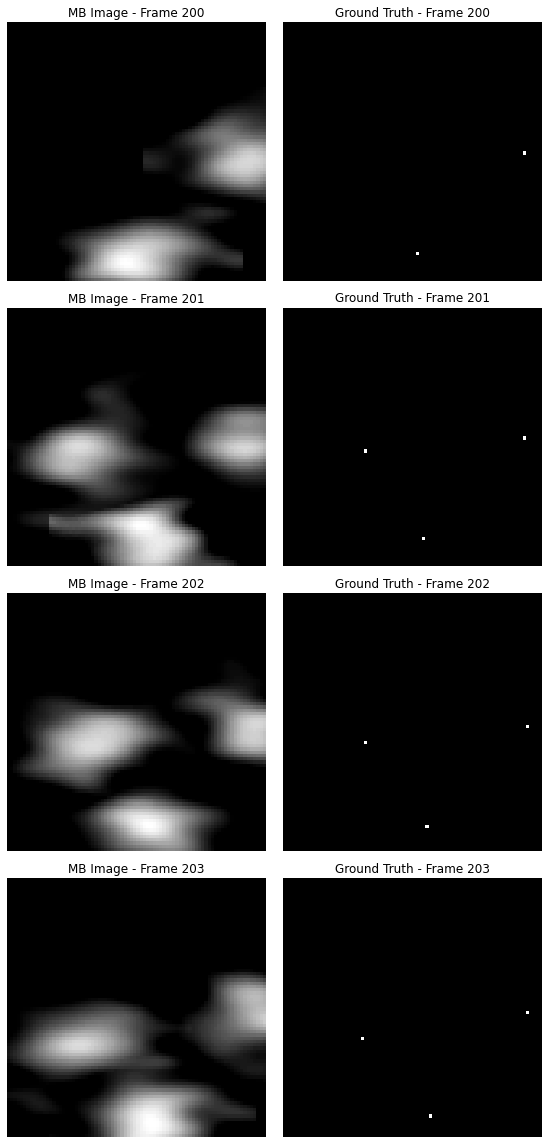

In [5]:
# ----- Display Generated Data -----

epoch = 1
dataset_train = SuperResDataset(length=1, n=n, b_mean=b_mean, b_std=b_std, v_min=v_min, v_max=v_max, t_start_min=t_start_min, t_start_max=t_start_max, t_dur_min=t_dur_min, t_dur_max=t_dur_max, t_end = t_end,
                                    psf_data_dir=psf_data_dir, Na=Na, Nl=Nl, Nt_in=Nt_in, epoch=epoch)
train_loader = DataLoader(dataset_train, batch_size=1, shuffle=False)

for data in train_loader:
    image, label_volume = data
    image, label_volume = image.to(device), label_volume.to(device)
    label_volume = label_volume.to(torch.float32)*255
    
     # -----  Display MB image and Positions -----  
     
    frame_num = 200

    num_frames_to_plot = 4

    fig, axes = plt.subplots(num_frames_to_plot, 2, figsize=(8, 4*num_frames_to_plot))
    for i in range(num_frames_to_plot):
        axes[i, 0].imshow(image[0][0][frame_num+i].cpu().data.numpy(), cmap='gray')
        axes[i, 0].set_title(f"MB Image - Frame {frame_num+i}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(label_volume[0][0][frame_num+i].cpu().data.numpy(), cmap='gray')
        axes[i, 1].set_title(f"Ground Truth - Frame {frame_num+i}")
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()